In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cpu')

# important commnet : 
Resnet is trained with 3 x 224 x 224 images . if we want use trained-resnet, it is so much better to used 224 x 224 images . it increase precision (even in one epoch got accuracy on testdata about 80%!) but huge computtion . and i dont have enough computation resources . so i use 28 x 28 images . structure of resnet is designed to work with different sizes and it works but pretrained weights are not as good as when 224 x 224 pixels is used. anyway i free colab account i have not another choice

true_transform = transforms.Compose([torchvision.transforms.Resize((224, 224)),transforms.ToTensor()])
'''

In [3]:

transform = transforms.Compose([torchvision.transforms.Resize((28, 28)),transforms.ToTensor()])
transform_KD = transforms.Compose([torchvision.transforms.Resize((224, 224)),transforms.ToTensor()]) 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset_KD = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_KD)
trainset_KD, valset_KD = torch.utils.data.random_split(trainset_KD, [45000, 5000])
testset_KD = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_KD)

# define dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

trainloader_KD = torch.utils.data.DataLoader(trainset_KD, batch_size=64, shuffle=True, num_workers=2)
valloader_KD = torch.utils.data.DataLoader(trainset_KD, batch_size=64, shuffle=False, num_workers=2)
testloader_KD = torch.utils.data.DataLoader(trainset_KD, batch_size=64, shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_teacher = torchvision.models.resnet50(pretrained=True) #test adding pretrained model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [5]:
def train(model, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=None,writer_name ="" , plot = False):
    model.train()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() 
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = running_corrects / len(trainloader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        if writer:
            writer.add_scalar(f'Training loss for {writer_name}', epoch_loss, epoch)
            writer.add_scalar(f'Training accuracy for {writer_name}', epoch_acc, epoch)
        
        print('Epoch {}/{} - Training loss: {:.4f} - Training accuracy: {:.4f}'.format(epoch+1, epochs, epoch_loss, epoch_acc))
        test_loss_, test_acc_ = test(model, testloader, criterion)
        test_loss.append(test_loss_)
        test_acc.append(test_acc_)
        if writer:
            writer.add_scalar(f'Test loss for {writer_name}', test_loss_, epoch)
            writer.add_scalar(f'Test accuracy for {writer_name}', test_acc_, epoch)
        val_loss_, val_acc_ = validate(model, valloader, criterion)

        val_loss.append(val_loss_)
        val_acc.append(val_acc_)
        if writer:
            writer.add_scalar(f'Validation loss for {writer_name}', val_loss_, epoch)
            writer.add_scalar(f'Validation accuracy for {writer_name}', val_acc_, epoch)
    if plot:
      plt.plot(train_acc, label='train')
      plt.plot(test_acc, label='test')
      plt.plot(val_acc, label='validation')
      plt.legend()
      plt.title('Accuracy')
      plt.show()
    print('Finished Training')
    return train_loss, train_acc, test_loss, test_acc, val_loss, val_acc

def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(testloader.dataset)
    epoch_acc = running_corrects / len(testloader.dataset)
    print('Test loss: {:.4f} - Test accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
    model.train()
    return epoch_loss, epoch_acc

def validate(model, valloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() 
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(valloader.dataset)
    epoch_acc = running_corrects / len(valloader.dataset)
    print('Validation loss: {:.4f} - Validation accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
    model.train()
    return epoch_loss, epoch_acc




def train_kd(model,teacher_model, trainloader, testloader, valloader, criterion, optimizer, epochs=10, writer=None, writer_name = '' , alpha=0.9, temperature=4,plot = False):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #get the outputs from the teacher model
            teacher_outputs = teacher_model(inputs)
            #calculate the knowledge distillation loss
            loss = alpha * criterion(outputs, labels) + (1-alpha) * temperature**2 * criterion(F.log_softmax(outputs/temperature, dim=1), F.softmax(teacher_outputs/temperature, dim=1))
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects / len(trainloader.dataset)
        print('Epoch {}/{} - Train loss: {:.4f} - Train accuracy: {:.4f}'.format(epoch + 1, epochs, epoch_loss, epoch_acc))
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        if writer:
            writer.add_scalar(f'Train loss in KD for {writer_name}', epoch_loss, epoch)
            writer.add_scalar(f'Train accuracy in KD for {writer_name}', epoch_acc, epoch)
        test_loss_, test_acc_ = test(model, testloader, criterion)
        test_loss.append(test_loss_)
        test_acc.append(test_acc_)
        if writer:
            writer.add_scalar(f'Test loss in KD for {writer_name}', test_loss_, epoch)
            writer.add_scalar(f'Test accuracy in KD for {writer_name}', test_acc_, epoch)
        val_loss_, val_acc_ = validate(model, valloader, criterion)
        val_loss.append(val_loss_)
        val_acc.append(val_acc_)
        if writer:
            writer.add_scalar(f'Validation loss in KD for {writer_name}', val_loss_, epoch)
            writer.add_scalar(f'Validation accuracy in KD for {writer_name}', val_acc_, epoch)
    print('Finished Training')
    if plot:
        plt.plot(train_acc, label='train')
        plt.plot(test_acc, label='test')
        plt.plot(val_acc, label='validation')
        plt.legend()
        plt.title('Accuracy')
        plt.show()
    return train_loss, train_acc, test_loss, test_acc, val_loss, val_acc


Epoch 1/5 - Training loss: 0.7401 - Training accuracy: 0.7471
Test loss: 0.0091 - Test accuracy: 0.8029
Validation loss: 0.0091 - Validation accuracy: 0.8029
Epoch 2/5 - Training loss: 0.6169 - Training accuracy: 0.7898
Test loss: 0.0084 - Test accuracy: 0.8147
Validation loss: 0.0084 - Validation accuracy: 0.8147
Epoch 3/5 - Training loss: 0.5775 - Training accuracy: 0.8014
Test loss: 0.0099 - Test accuracy: 0.7774
Validation loss: 0.0099 - Validation accuracy: 0.7774
Epoch 4/5 - Training loss: 0.5676 - Training accuracy: 0.8046
Test loss: 0.0075 - Test accuracy: 0.8333
Validation loss: 0.0075 - Validation accuracy: 0.8333
Epoch 5/5 - Training loss: 0.5540 - Training accuracy: 0.8103
Test loss: 0.0071 - Test accuracy: 0.8431
Validation loss: 0.0071 - Validation accuracy: 0.8431



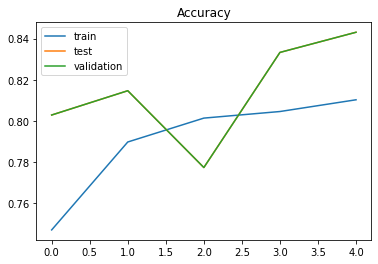

In [ ]:
#import pretrained model resnet50 on imagenet and replace the last layer with a new layer with 10 classes
model_teacher = torchvision.models.resnet50(pretrained=True)
model_teacher.fc = nn.Linear(2048, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_teacher.to(device)
epochs = 5
best_lr = 0.01 # i checked but deleted cell to no run again!
writer = SummaryWriter('runs/teacher')
#freeze all layers except the last layer
for param in model_teacher.parameters():
    param.requires_grad = False
model_teacher.fc.weight.requires_grad = True
model_teacher.fc.bias.requires_grad = True
#use cross entropy loss
criterion = nn.CrossEntropyLoss()
#use SGD optimizer
optimizer = optim.SGD(model_teacher.parameters(), lr=best_lr, momentum=0.9) #learnin_rate is found in previous step
train_loss_teacher, train_acc_teacher, test_loss_teacher, test_acc_teacher, val_loss_teacher, val_acc_teacher = train(model_teacher, trainloader_KD, testloader_KD, valloader_KD, criterion, optimizer, epochs=epochs, writer=writer, writer_name = 'teacher' ,plot = True)

In [ ]:
# checking to add resnet 18 
model_student = torchvision.models.resnet18(pretrained=False)
model_student.fc = nn.Linear(512, 10)




/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
# find best Alpha and temperature
best_acc = 0
best_alpha = 0
best_temperature = 0
epochs = 1
for alpha in [0.2,0.5,0.8]:
    for temperature in [1,10,20]: #my resource is limited and i cnat test lots of values

        print(f"~~~~~ Check alpha : {alpha} and temperature : {temperature} ~~~~ \n")
        model_student = torchvision.models.resnet18(pretrained=False)
        model_student.fc = nn.Linear(512, 10)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_student.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model_student.parameters(), lr=0.001 , momentum=0.9)
        train_loss, train_acc, test_loss, test_acc, val_loss, val_acc = train_kd(model_student, model_teacher, trainloader_KD, testloader_KD, valloader_KD, criterion, optimizer, alpha = alpha, temperature = temperature, epochs=epochs, writer=None, writer_name = '' ,plot = False)
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            best_alpha = alpha
            best_temperature = temperature
            torch.save(model_student.state_dict(), "best_model.pth")
print(f"Best accuracy: {best_acc} - Best alpha: {best_alpha} - Best temperature: {best_temperature}")


~~~~~ Check alpha : 0.2 and temperature : 2 ~~~~ 

Epoch 1/1 - Train loss: 0.1135 - Train accuracy: 0.3899
Test loss: 0.0235 - Test accuracy: 0.4738
Test loss: 0.02349014308055242 - Test accuracy: 0.4737777777777778
Validation loss: 0.0235 - Validation accuracy: 0.4738
Validation loss: 0.02349014308055242 - Validation accuracy: 0.4737777777777778
Finished Training
~~~~~ Check alpha : 0.2 and temperature : 4 ~~~~ 

Epoch 1/1 - Train loss: 0.4582 - Train accuracy: 0.3855
Test loss: 0.0233 - Test accuracy: 0.4757
Test loss: 0.023289071114857993 - Test accuracy: 0.47573333333333334
Validation loss: 0.0233 - Validation accuracy: 0.4757
Validation loss: 0.023289071114857993 - Validation accuracy: 0.47573333333333334
Finished Training
~~~~~ Check alpha : 0.2 and temperature : 6 ~~~~ 

Epoch 1/1 - Train loss: 1.0343 - Train accuracy: 0.3919
Test loss: 0.0232 - Test accuracy: 0.4730
Test loss: 0.02316356581846873 - Test accuracy: 0.47302222222222223
Validation loss: 0.0232 - Validation accurac


Epoch 1/5 - Train loss: 0.0764 - Train accuracy: 0.3882
Test loss: 0.0344 - Test accuracy: 0.3556
Validation loss: 0.0344 - Validation accuracy: 0.3556
Epoch 2/5 - Train loss: 0.0685 - Train accuracy: 0.5354
Test loss: 0.0194 - Test accuracy: 0.5454
Validation loss: 0.0194 - Validation accuracy: 0.5454
Epoch 3/5 - Train loss: 0.0647 - Train accuracy: 0.6112
Test loss: 0.0256 - Test accuracy: 0.5117
Validation loss: 0.0256 - Validation accuracy: 0.5117
Epoch 4/5 - Train loss: 0.0621 - Train accuracy: 0.6651
Test loss: 0.0135 - Test accuracy: 0.6949
Epoch 5/5 - Train loss: 0.0601 - Train accuracy: 0.7021
Test loss: 0.0115 - Test accuracy: 0.7424
Validation loss: 0.0115 - Validation accuracy: 0.7424



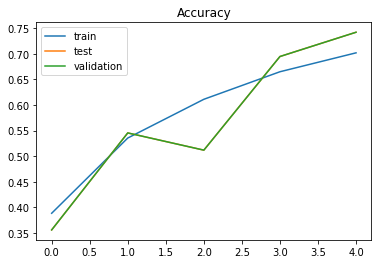

In [ ]:
#train student model with best hyperparameters for 10 epochs and save the model
model_student = torchvision.models.resnet18(pretrained=False)
model_student.fc = nn.Linear(512, 10)
model_student.to(device)
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_student.parameters(), lr=0.001, momentum = 0.9) #learning rate is found in previous step
train_loss_student, train_acc_student, test_loss_student, test_acc_student, val_loss_student, val_acc_student = train_kd(model_student, model_teacher, trainloader_KD, testloader_KD, valloader_KD, criterion, optimizer, alpha = best_alpha, temperature = best_temperature, epochs=epochs, writer=writer, writer_name = 'student' ,plot = True)

In [6]:
# best learning rate to train torchvision.models.resnet18 witoout KD 
best_acc = 0
best_lr = 0
epochs = 1
for lr in [0.0001,0.001,0.01,0.1]:
    print(f"~~~~~ Check learning rate : {lr} ~~~~ \n")
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = nn.Linear(512, 10)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_loss, train_acc, test_loss, test_acc, val_loss, val_acc = train(model, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=None)
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_lr = lr
print('~~~ best learning rate ~~~')
print(f'Best lr based on {epochs} epochs : {best_lr}')

~~~~~ Check learning rate : 0.0001 ~~~~ 

Epoch 1/1 - Training loss: 1.9276 - Training accuracy: 0.3006
Test loss: 0.0262 - Test accuracy: 0.3965
Validation loss: 0.0262 - Validation accuracy: 0.3965
Finished Training
~~~~~ Check learning rate : 0.001 ~~~~ 

Epoch 1/1 - Training loss: 1.6153 - Training accuracy: 0.4136
Test loss: 0.0232 - Test accuracy: 0.4719
Validation loss: 0.0232 - Validation accuracy: 0.4719
Finished Training
~~~~~ Check learning rate : 0.01 ~~~~ 

Epoch 1/1 - Training loss: 1.6379 - Training accuracy: 0.4292
Test loss: 0.0229 - Test accuracy: 0.4974
Validation loss: 0.0229 - Validation accuracy: 0.4974
Finished Training
~~~~~ Check learning rate : 0.1 ~~~~ 

Epoch 1/1 - Training loss: 1.9651 - Training accuracy: 0.3262
Test loss: 0.0235 - Test accuracy: 0.4586
Validation loss: 0.0235 - Validation accuracy: 0.4586
Finished Training
~~~ best learning rate ~~~
Best lr based on 1 epochs : 0.01


Epoch 1/5 - Training loss: 2.1681 - Training accuracy: 0.2690
Test loss: 0.0319 - Test accuracy: 0.3083
Validation loss: 0.0319 - Validation accuracy: 0.3083
Epoch 2/5 - Training loss: 2.1552 - Training accuracy: 0.2821
Test loss: 0.0329 - Test accuracy: 0.3047
Validation loss: 0.0329 - Validation accuracy: 0.3047
Epoch 3/5 - Training loss: 2.1415 - Training accuracy: 0.2842
Test loss: 0.0337 - Test accuracy: 0.2906
Validation loss: 0.0337 - Validation accuracy: 0.2906
Epoch 4/5 - Training loss: 2.1620 - Training accuracy: 0.2806
Test loss: 0.0304 - Test accuracy: 0.3272
Validation loss: 0.0304 - Validation accuracy: 0.3272
Epoch 5/5 - Training loss: 2.1650 - Training accuracy: 0.2844
Test loss: 0.0359 - Test accuracy: 0.2882
Validation loss: 0.0359 - Validation accuracy: 0.2882


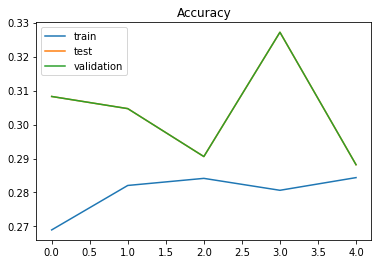

Finished Training


In [7]:
#train pretrained resnet18 model for cifar10 dataset. freeze all layer except the last one and train it with cross entropy loss function
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)
criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.SGD(resnet18.fc.parameters(), lr=best_lr, momentum=0.9) #learning rate is found in previous step
train_loss_resnet18_alone, train_acc_resnet18_alone, test_loss_resnet18_alone, test_acc_resnet18_alone, val_loss_resnet18_alone, val_acc_resnet18_alone = train(resnet18, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=None, plot = True)

Epoch 1/5 - Training loss: 0.3921 - Training accuracy: 0.8683
Test loss: 0.0025 - Test accuracy: 0.9445
Validation loss: 0.0025 - Validation accuracy: 0.9445
Epoch 2/5 - Training loss: 0.1702 - Training accuracy: 0.9417
Test loss: 0.0017 - Test accuracy: 0.9638
Validation loss: 0.0017 - Validation accuracy: 0.9638
Epoch 3/5 - Training loss: 0.1080 - Training accuracy: 0.9624
Test loss: 0.0010 - Test accuracy: 0.9782
Validation loss: 0.0010 - Validation accuracy: 0.9782
Epoch 4/5 - Training loss: 0.0650 - Training accuracy: 0.9777
Test loss: 0.0006 - Test accuracy: 0.9869
Validation loss: 0.0006 - Validation accuracy: 0.9869
Epoch 5/5 - Training loss: 0.0450 - Training accuracy: 0.9844
Test loss: 0.0006 - Test accuracy: 0.9863
Validation loss: 0.0006 - Validation accuracy: 0.9863


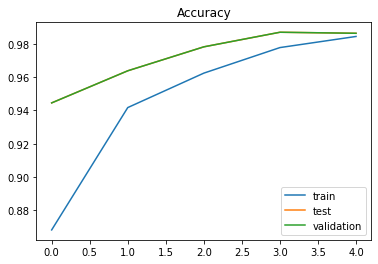

Finished Training


In [21]:

# fine tune the pretrained resnet50 model for cifar10 dataset. unfreeze all layers and train it with cross entropy loss function and used trained network
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
criterion = nn.CrossEntropyLoss()
best_lr = 0.01 #i check but deleted cell to dont run again!
epochs = 5
optimizer = optim.SGD(resnet50.parameters(), lr=best_lr, momentum=0.9) 
train_loss_resnet50_alone_all_unfreazed, train_acc_resnet50_alone_all_unfreazed, test_loss_resnet50_alone_all_unfreazed, test_acc_resnet50_alone_all_unfreazed, val_loss_resnet50_alone_all_unfreazed, val_acc_resnet50_alone_all_unfreazed = train(resnet50, trainloader_KD, testloader_KD, valloader_KD, criterion, optimizer, epochs, writer=None, plot = True)

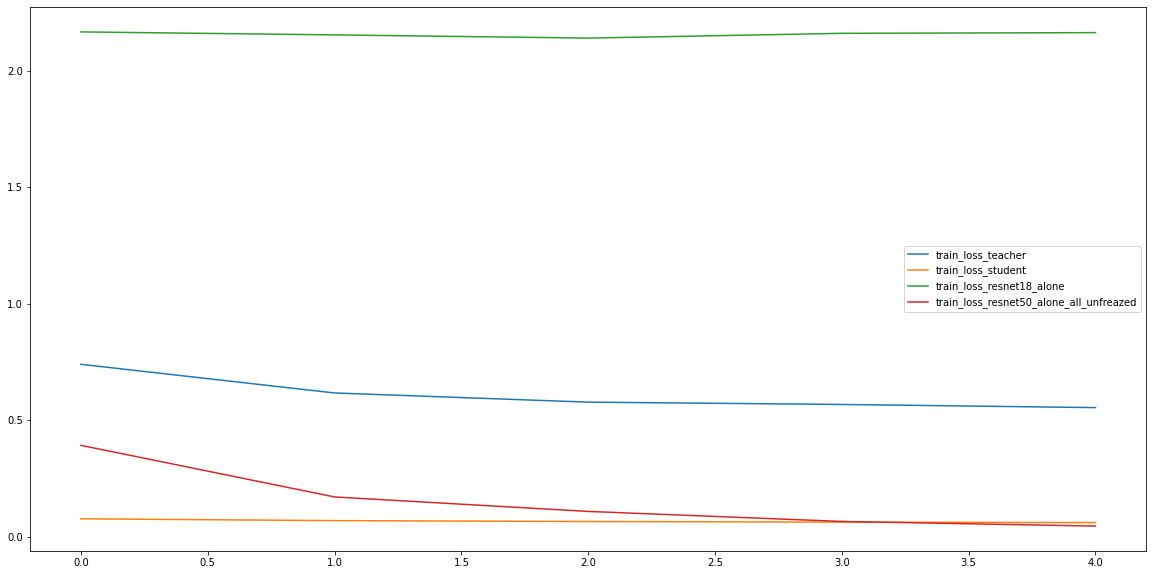

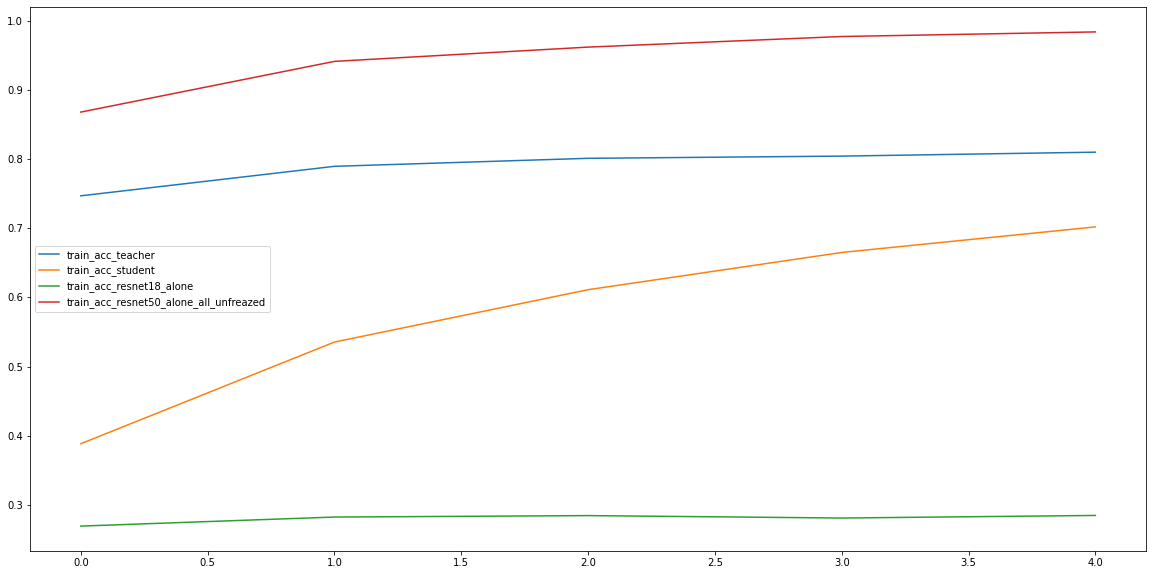

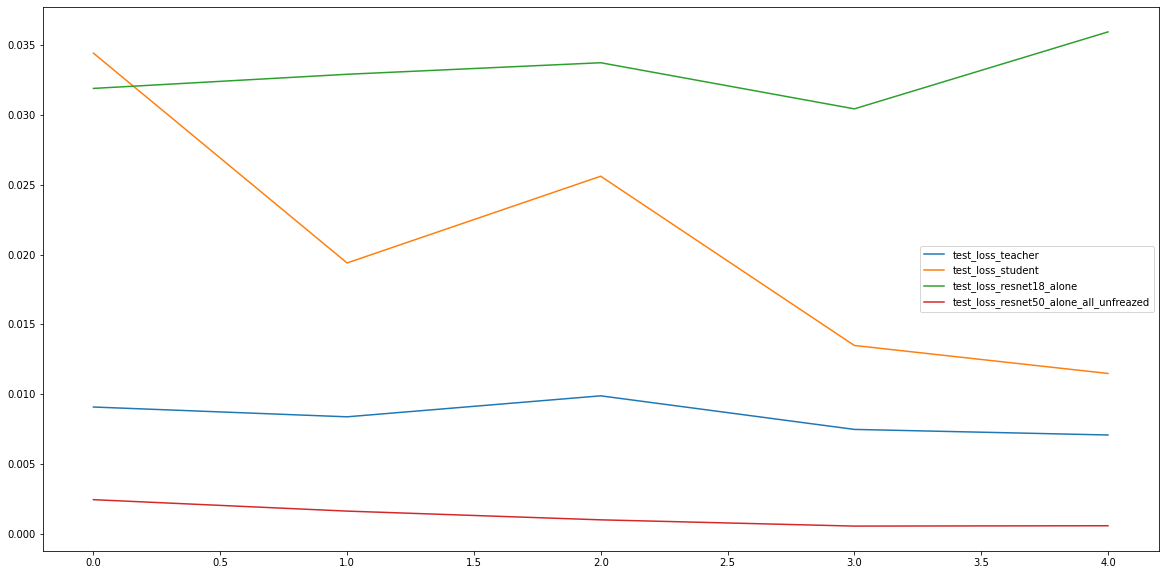

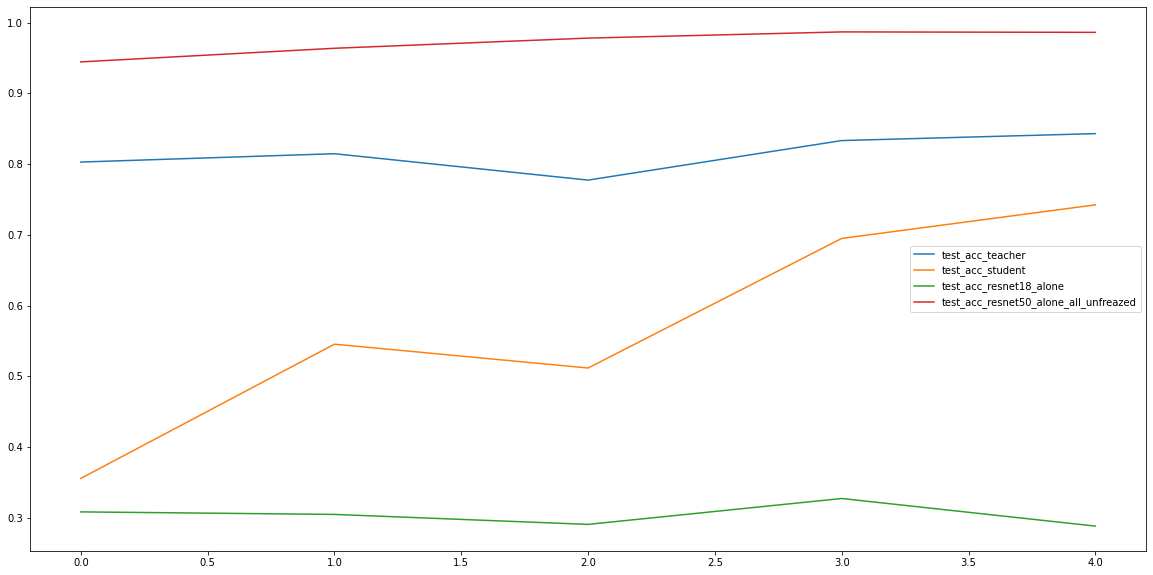

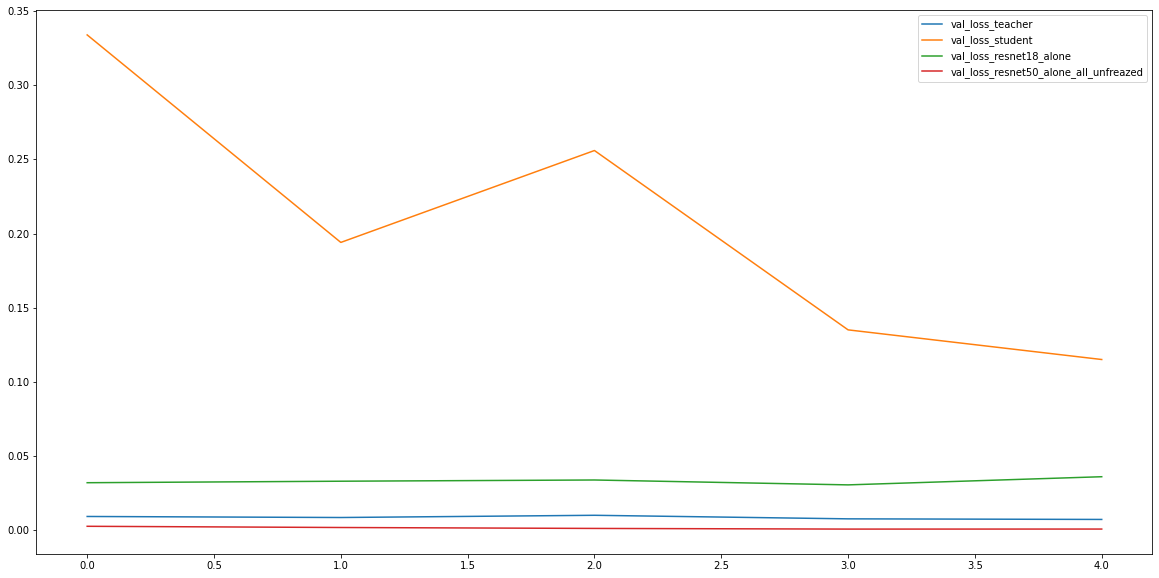

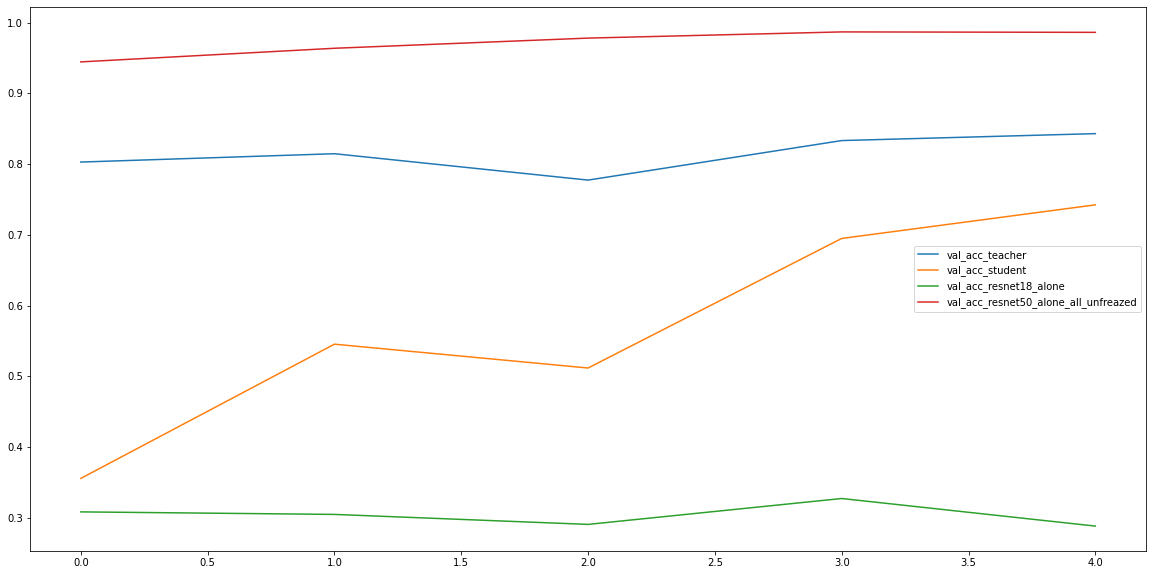

In [23]:
# plot the train loss for all models
plt.figure(figsize=(20,10))
plt.plot(train_loss_teacher, label="train_loss_teacher")
plt.plot(train_loss_student, label="train_loss_student")
plt.plot(train_loss_resnet18_alone, label="train_loss_resnet18_alone")
plt.plot(train_loss_resnet50_alone_all_unfreazed, label="train_loss_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()
# plot the train accuracy for all models
plt.figure(figsize=(20,10))
plt.plot(train_acc_teacher, label="train_acc_teacher")
plt.plot(train_acc_student, label="train_acc_student")
plt.plot(train_acc_resnet18_alone, label="train_acc_resnet18_alone")    
plt.plot(train_acc_resnet50_alone_all_unfreazed, label="train_acc_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()
# plot the test loss for all models
plt.figure(figsize=(20,10))
plt.plot(test_loss_teacher, label="test_loss_teacher")
plt.plot(test_loss_student, label="test_loss_student")
plt.plot(test_loss_resnet18_alone, label="test_loss_resnet18_alone")
plt.plot(test_loss_resnet50_alone_all_unfreazed, label="test_loss_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()
# plot the test accuracy for all models
plt.figure(figsize=(20,10))
plt.plot(test_acc_teacher, label="test_acc_teacher")
plt.plot(test_acc_student, label="test_acc_student")
plt.plot(test_acc_resnet18_alone, label="test_acc_resnet18_alone")
plt.plot(test_acc_resnet50_alone_all_unfreazed, label="test_acc_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()
# plot the validation loss for all models
plt.figure(figsize=(20,10))
plt.plot(val_loss_teacher, label="val_loss_teacher")
plt.plot(val_loss_student, label="val_loss_student")
plt.plot(val_loss_resnet18_alone, label="val_loss_resnet18_alone")
plt.plot(val_loss_resnet50_alone_all_unfreazed, label="val_loss_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()
# plot the validation accuracy for all models
plt.figure(figsize=(20,10))
plt.plot(val_acc_teacher, label="val_acc_teacher")
plt.plot(val_acc_student, label="val_acc_student")
plt.plot(val_acc_resnet18_alone, label="val_acc_resnet18_alone")
plt.plot(val_acc_resnet50_alone_all_unfreazed, label="val_acc_resnet50_alone_all_unfreazed")
plt.legend()
plt.show()




 ### QUESTION ASKED ###
important : 
because of resource limitation i just run all models for 5 Epochs and all the conculations are based on that number of epochs

** Q1 : check result of part A is in above and i plot accuracies and loss
** Q2 : USING KD : we see that it learns faster than training resnet18 from first and teacher model help to learns faster . if we train resnet18 without KD and untrained , the result is not good enough (as you see in above figures)
** Q3 : if we fine-tune all the networks of resnet-50 VS just FC layer:
in this number of epochs (5 epochs) if we train all the models (with good learning rate) result is better but computation time is huge different (more than 10times in my run on COLAB GPU). resnet50 is a big model and it is not surprising  .furthermore, I think because size of our dataset is not big enough and in lots number of epochs overfitting is possible (i dont check it)